In [1]:
import os
import sys
sys.path.append('/home/souravc83/trading_ideas')
%load_ext autoreload
%autoreload 2

In [2]:
from src.stock import Stock, Holding, Universe
from src.backtest import BackTest
from src.linreg_strategy import LinRegStrategy
from src.factor import (
    LinRegFactor, 
    linreg_stock, 
    MovingAverageFactor,
    PercReturnFactor
)
from src.read_write import ReadData, check_valid_symbol

/home/souravc83/.local/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from typing import List

In [4]:
# read the file and filter
offline_filename = '/home/souravc83/trading_ideas/src/data/offline_price_data.csv'
all_df = pd.read_csv(offline_filename)
all_df['daily_change'] = (all_df['High'] - all_df['Low'])/all_df['High']
all_df['date'] = pd.to_datetime(all_df['date'])
all_df = all_df.sort_values(by=['symbol', 'date'])
all_df.head()

,Open,High,Low,Close,Adj Close,Volume,symbol,date,daily_change
115788,41.180000,41.310001,40.369999,40.560001,38.553932,1529200.0,A,2015-01-02,0.022755
115789,40.320000,40.459999,39.700001,39.799999,37.831524,2041800.0,A,2015-01-05,0.018784
115790,39.810001,40.020000,39.020000,39.180000,37.242188,2080600.0,A,2015-01-06,0.024988
115791,39.520000,39.810001,39.290001,39.700001,37.736473,3359700.0,A,2015-01-07,0.013062
115792,40.240002,40.980000,40.180000,40.889999,38.867619,2116300.0,A,2015-01-08,0.019522


In [5]:
## define a bunch of grouping functions
## These functions take a series and 
## return a number

def beta_7(x):
    time = 7
    end = x.values.shape[0]
    start = end - time
    y_val = x.values[start: end]
    y_val = y_val / y_val[0]
    x_val = list(range(y_val.shape[0]))
    x_val = sm.add_constant(x_val)
    model = sm.OLS(y_val, x_val)
    res = model.fit()
    beta_val = res.params[1]
    return beta_val

def beta_30(x):
    time = 30
    end = x.values.shape[0]
    start = end - time
    y_val = x.values[start : end]
    y_val = y_val / y_val[0]
    x_val = list(range(y_val.shape[0]))
    x_val = sm.add_constant(x_val)
    model = sm.OLS(y_val, x_val)
    res = model.fit()
    beta_val = res.params[1]
    return beta_val

def beta_30_var(x):
    time = 30
    end = x.values.shape[0]
    start = end - time
    y_val = x.values[start : end]
    y_val = y_val / y_val[0]
    x_val = list(range(y_val.shape[0]))
    x_val = sm.add_constant(x_val)
    model = sm.OLS(y_val, x_val)
    res = model.fit()
    beta_ci = res.conf_int(alpha=0.05)[1]
    return (beta_ci[1] - beta_ci[0])

def beta_7_var(x):
    time = 7
    end = x.values.shape[0]
    start = end - time
    y_val = x.values[start : end]
    y_val = y_val / y_val[0]
    x_val = list(range(y_val.shape[0]))
    x_val = sm.add_constant(x_val)
    model = sm.OLS(y_val, x_val)
    res = model.fit()
    beta_ci = res.conf_int(alpha=0.05)[1]
    return (beta_ci[1] - beta_ci[0])
    

def ma_fac(x):
    end = x.values.shape[0]
    short_start = end - 15
    long_start = end - 30
    
    short_ma = np.mean(x.values[short_start:end])
    long_ma = np.mean(x.values[long_start:end])
    
    return short_ma/long_ma

def perc_log_return(x):
    current = x.values[0]
    future = x.values[-1]
    
    return np.log10(future/current)

def perc_max_return(x):
    future = x.values[1:]/x.values[0]
    return np.max(future)
    

def short_mean_val(x):
    end = x.values.shape[0]
    short_start = end - 7
    short_ma = np.mean(x.values[short_start:end])
    return short_ma

def long_mean_val(x):
    end = x.values.shape[0]
    long_start = end - 30
    long_ma = np.mean(x.values[long_start:end])
    return long_ma

def second_deriv(x):
    time = 30
    end = x.values.shape[0]
    start = end - time
    y_val = x.values[start : end]
    y_val = y_val / y_val[0]
    x_val = list(range(y_val.shape[0]))
    
    loess = sm.nonparametric.lowess
    y_loess = loess(y_val, x_val, frac=0.2)
    second_deriv = np.gradient(np.gradient(y_loess[:,1]))
    
    return second_deriv[-1]

# helper functions
def find_crossing_points(x):
    N = x.shape[0]
    crossing = []
    for i in range(x.shape[0] - 1):
        if np.sign(x[i]) != np.sign(x[i+1]):
            crossing.append(i)
    return crossing

def is_abcd_buy(y_val, second_deriv, crossings):
    abcd_bool = 0
    abcd_strength = 0.
    flag = 0
    y_val_c = 0
    for cross in reversed(crossings):
        if second_deriv[cross] > 0 and flag == 0:
            flag = 1
            y_val_c = y_val[cross]
            
        if second_deriv[cross] < 0 and flag == 1:
            flag = 2
        
        if second_deriv[cross] > 0 and flag == 2:
            if y_val[cross] < y_val_c:
                abcd_bool = 1
                abcd_strength = y_val_c - y_val[cross]
    return abcd_strength

def abcd_pattern(x):
    time = 30
    end = x.values.shape[0]
    start = end - time
    y_val = x.values[start : end]
    y_val = y_val / y_val[0]
    x_val = list(range(y_val.shape[0]))
    
    loess = sm.nonparametric.lowess
    y_loess = loess(y_val, x_val, frac=0.2)
    loess_fit = y_loess[:,1]
    first_deriv = np.gradient(loess_fit)
    second_deriv = np.gradient(np.gradient(loess_fit))
    crossings = find_crossing_points(first_deriv)
    if len(crossings) > 0:
        return is_abcd_buy(loess_fit, second_deriv, crossings)
    else:
        return 0


In [16]:
def get_features(start_date: str, end_date: str) -> pd.DataFrame:
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

    df_dates = all_df[
        (all_df['date'] >= start_date_dt) &
        (all_df['date'] <= end_date_dt)
    ]
    df_dates=df_dates.sort_values(by='date')
    
    grp_df = df_dates.groupby(by='symbol').agg(
        {'Open': [beta_7, beta_30, beta_30_var, beta_7_var,
                  ma_fac, second_deriv, abcd_pattern],
         'Volume':[beta_7, beta_30, beta_30_var, beta_7_var],
         'daily_change':[short_mean_val, long_mean_val]
        }
    )
    
    
    
    grp_df.columns = ['_'.join(col).strip() for col in grp_df.columns]
    grp_df = grp_df.sort_values(by='symbol')
    grp_df = grp_df.reset_index()
    
    return grp_df
    

def get_labels(start_date: str, end_date: str) -> pd.DataFrame:
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

    df_dates = all_df[
        (all_df['date'] >= start_date_dt) &
        (all_df['date'] <= end_date_dt)
    ]
    df_dates=df_dates.sort_values(by='date')
    
    grp_df = df_dates.groupby(by='symbol').agg(
        {'Open': [perc_max_return]}
    )
    
    grp_df.columns = ['_'.join(col).strip() for col in grp_df.columns]
    grp_df = grp_df.sort_values(by='symbol')
    grp_df = grp_df.reset_index()
    
    return grp_df

def get_xy_mat(features: pd.DataFrame, 
               labels: pd.DataFrame, 
               colnames: List[str] =  None):
    
    
    label_colname = 'Open_perc_max_return'
    if colnames is None:
        colnames = [x for x in features.columns if x not in ['symbol', label_colname]]
    
    #colnames = ['Open_beta_7', 'Open_beta_30', 'Open_ma_fac',
    #            'Open_beta_7_var', 'Open_second_deriv', 'Open_abcd_pattern',
    #            'Open_beta_30_var', 'Volume_beta_7', 'Volume_beta_30',
    #            'Volume_beta_7_var',
    #            'Volume_beta_30_var', 'daily_change_short_mean_val',
    #            'daily_change_long_mean_val']
    
    features_df = features[colnames]
    
    full_df = pd.merge(features, labels, on='symbol')
    #features_df = features_df.sort_values(by='symbol')
    full_df = full_df.dropna()
    x_val = full_df[colnames].values
    y_val = full_df['Open_perc_max_return'].values
    
    return x_val, y_val
    #return full_df
    
def interpret_predictions(test_features, y_test, y_pred, 
                          training_start_date,
                          training_end_date, test_end_date):
    
    test_features['y_pred'] = y_pred
    test_features['y_test'] = y_test
    pred_df = test_features[['symbol', 'y_test', 'y_pred']]
    pred_df = pred_df.sort_values(by='y_pred', ascending=False)
    
    top_symbols = pred_df['symbol'].values[0:6]
    
    
    training_start_dt = datetime.strptime(training_start_date, '%Y-%m-%d')
    training_end_dt = datetime.strptime(training_end_date, '%Y-%m-%d')
    test_end_dt = datetime.strptime(test_end_date, '%Y-%m-%d')
    

    df_dates = all_df[
        (all_df['date'] >= training_start_dt) &
        (all_df['date'] <= test_end_dt)
    ]
    
    select_df = test_features[test_features['symbol'].isin(top_symbols)]
    print(select_df)
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
    for i in range(2):
        for j in range(3):
            index = i*3 + j
            symbol = top_symbols[index]
            
            df_symbol = df_dates.query(f"symbol=='{symbol}'")
            current_value = df_symbol.query(
                f"date=='{training_end_date}'")['Open'].values[0]
            
            df_symbol = df_symbol.sort_values(by='date')
            
            prediction = pred_df.query(
                f"symbol=='{symbol}'"
            )['y_pred'].values[0] * current_value
            
            actual = pred_df.query(
                f"symbol=='{symbol}'"
            )['y_test'].values[0] * current_value
            

            df_symbol['date'] = pd.to_datetime(df_symbol['date'])

            ax[i][j].set_title(symbol)
            ax[i][j].plot(df_symbol.date, df_symbol.Open, 'r--')
            ax[i][j].xaxis.set_tick_params(rotation=45)


            ax[i][j].vlines(
                x=training_end_dt, 
                ymin=np.min(df_symbol['Open'].values), 
                ymax=np.max(df_symbol['Open'].values)
            )

            ax[i][j].hlines(
                y=current_value,
                xmin=training_start_dt,
                xmax=training_end_dt,
                colors='b',
                linestyles='dashed'
            )
            
            ax[i][j].hlines(
                y=prediction,
                xmin=training_start_dt,
                xmax=training_end_dt,
                colors='g',
                linestyles='dashed'
            )
            
            ax[i][j].hlines(
                y=actual,
                xmin=training_start_dt,
                xmax=training_end_dt,
                colors='k',
                linestyles='dashed'
            )
            
    fig.tight_layout(pad=3.0)
    
def interpret_now(test_features, y_pred, 
                  training_start_date,training_end_date):
    test_features['y_pred'] = y_pred

    pred_df = test_features[['symbol', 'y_pred']]
    pred_df = pred_df.sort_values(by='y_pred', ascending=False)
    
    top_symbols = pred_df['symbol'].values[0:6]
    
    
    training_start_dt = datetime.strptime(training_start_date, '%Y-%m-%d')
    training_end_dt = datetime.strptime(training_end_date, '%Y-%m-%d')
    

    df_dates = all_df[
        (all_df['date'] >= training_start_dt) &
        (all_df['date'] <= training_end_dt)
    ]
    
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
    for i in range(2):
        for j in range(3):
            index = i*3 + j
            symbol = top_symbols[index]
            
            df_symbol = df_dates.query(f"symbol=='{symbol}'")
            current_value = df_symbol.query(
                f"date=='{training_end_date}'")['Open'].values[0]
            
            df_symbol = df_symbol.sort_values(by='date')
            
            
            prediction = pred_df.query(
                f"symbol=='{symbol}'"
            )['y_pred'].values[0] * current_value
            

            df_symbol['date'] = pd.to_datetime(df_symbol['date'])

            ax[i][j].set_title(symbol)
            ax[i][j].plot(df_symbol.date, df_symbol.Open, 'r--')
            ax[i][j].xaxis.set_tick_params(rotation=45)


            ax[i][j].hlines(
                y=current_value,
                xmin=training_start_dt,
                xmax=training_end_dt,
                colors='b',
                linestyles='dashed'
            )
            
            ax[i][j].hlines(
                y=prediction,
                xmin=training_start_dt,
                xmax=training_end_dt,
                colors='g',
                linestyles='dashed'
            )
            
            
    fig.tight_layout(pad=3.0)
    
def ols_feature_importance(features: pd.DataFrame, labels: pd.DataFrame, 
                           colnames: List[str] = None):
    full_df = pd.merge(features, labels, on='symbol')
    full_df = full_df.dropna()
    label_colname = 'Open_perc_max_return'
    
    if colnames is None:
        feature_colnames = [x for x in full_df.columns if x not in ['symbol', label_colname]]
    else:
        feature_colnames = colnames

    X_val = full_df[feature_colnames]
    X_val = sm.add_constant(X_val) 
    Y_val = full_df['Open_perc_max_return']
    
    model = sm.OLS(Y_val, X_val)
    
    results = model.fit()
    
    print(results.summary())
    
    
    
    

In [10]:
colnames = ['Open_beta_7', 'Open_beta_30',
            'Open_beta_7_var', 'Open_beta_30_var',
            'daily_change_short_mean_val'
           ]

In [11]:
training_start_date = '2020-04-02'
training_end_date = '2020-05-15'
training_label_start_date = training_end_date
training_label_end_date = '2020-05-29'


training_features = get_features(
    start_date=training_start_date,
    end_date=training_end_date)
training_labels = get_labels(
    start_date=training_label_start_date,
    end_date=training_label_end_date
)

x_val_train, y_val_train = get_xy_mat(
    features=training_features, 
    labels=training_labels,
    colnames=colnames
)
#full_df = get_xy_mat(features=training_features, labels=training_labels)

In [12]:
test_start_date = '2020-04-17'
test_end_date = '2020-06-01'
test_label_start_date = test_end_date
test_label_end_date = '2020-06-14'


test_features = get_features(
    start_date=test_start_date,
    end_date=test_end_date)
test_labels = get_labels(
    start_date=test_label_start_date,
    end_date=test_label_end_date
)

x_val_test, y_val_test = get_xy_mat(
    features=test_features, 
    labels=test_labels,
    colnames=colnames
)


In [13]:
# Linear Regression
clf_linear = linear_model.LinearRegression()

clf_linear.fit(x_val_train, y_val_train)
y_pred_linear = clf_linear.predict(x_val_test)
clf_linear.score(x_val_test, y_val_test)


0.5499489366620758

    symbol  Open_beta_7  Open_beta_30  Open_beta_30_var  Open_beta_7_var  \
43     APA    -0.013203      0.011387          0.013054         0.059172   
114   COTY     0.036467     -0.015658          0.008491         0.113324   
227    HOG    -0.011010      0.009459          0.007904         0.076140   
268    JWN     0.018944     -0.003522          0.007285         0.096282   
339   NCLH     0.032793      0.010289          0.013178         0.109956   
462    UAL     0.018903     -0.000296          0.009087         0.091506   

     Open_ma_fac  Open_second_deriv  Open_abcd_pattern  Volume_beta_7  \
43      1.039680          -0.003382           0.000000       0.175885   
114     0.839574          -0.002292           0.000000       0.263103   
227     1.047803          -0.001012           0.070180       0.096348   
268     0.956590          -0.001676           0.015926       0.162723   
339     1.038772          -0.005812           0.000000      -0.008686   
462     0.980374          -0.

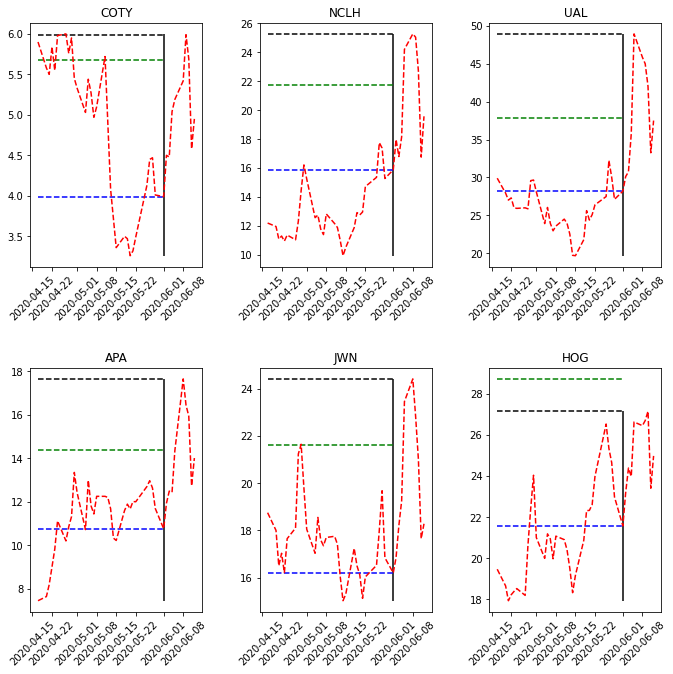

In [14]:
# interpret 
interpret_predictions(
    test_features=test_features, 
    y_test=y_val_test,
    y_pred=y_pred_linear, 
    training_start_date=test_start_date,
    training_end_date=test_end_date, 
    test_end_date=test_label_end_date
)

In [17]:
ols_feature_importance(training_features, training_labels, colnames)


                             OLS Regression Results                             
Dep. Variable:     Open_perc_max_return   R-squared:                       0.657
Model:                              OLS   Adj. R-squared:                  0.654
Method:                   Least Squares   F-statistic:                     216.9
Date:                  Fri, 03 Jul 2020   Prob (F-statistic):          6.72e-129
Time:                          23:59:38   Log-Likelihood:                 785.31
No. Observations:                   571   AIC:                            -1559.
Df Residuals:                       565   BIC:                            -1533.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

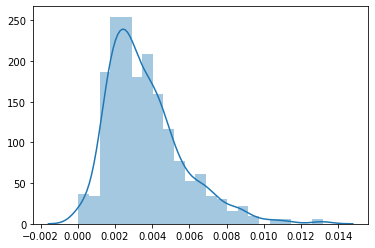

In [19]:
sns.distplot(test_features['Open_beta_30_var'].values)

In [109]:
# Support Vector Machines
clf_svm = svm.SVR()

clf_svm.fit(x_val_train, y_val_train)
clf_svm.score(x_val_test, y_val_test)

0.35745120340969705

In [110]:
#Random Forest
clf_rf = RandomForestRegressor(n_estimators=50)

clf_rf.fit(x_val_train, y_val_train)
clf_rf.score(x_val_test, y_val_test)

0.5085091093988271

In [111]:
#Gradient Boosted Trees
clf_gbm = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1,
                          max_depth=1, random_state=0, loss='ls')

clf_gbm.fit(x_val_train, y_val_train)
clf_gbm.score(x_val_test, y_val_test)

0.4798465669054951

In [13]:
ols_feature_importance(training_features, training_labels)
    
    

                             OLS Regression Results                             
Dep. Variable:     Open_perc_max_return   R-squared:                       0.671
Model:                              OLS   Adj. R-squared:                  0.663
Method:                   Least Squares   F-statistic:                     87.40
Date:                  Fri, 03 Jul 2020   Prob (F-statistic):          3.91e-125
Time:                          22:44:06   Log-Likelihood:                 796.83
No. Observations:                   571   AIC:                            -1566.
Df Residuals:                       557   BIC:                            -1505.
Df Model:                            13                                         
Covariance Type:              nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [113]:
sm_ols(x_val_train, y_val_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     87.40
Date:                Thu, 25 Jun 2020   Prob (F-statistic):          3.91e-125
Time:                        01:36:49   Log-Likelihood:                 796.83
No. Observations:                 571   AIC:                            -1566.
Df Residuals:                     557   BIC:                            -1505.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0323      0.387      0.083      0.9

In [21]:
#predict for today
today_pred_start_date = '2020-05-29'
today_pred_end_date = '2020-06-24'
today_features = get_features(
    start_date=today_pred_start_date,
    end_date=today_pred_end_date)

colnames = ['Open_beta_7', 'Open_beta_30', 
                'Open_beta_7_var', 
                'Open_beta_30_var', 'daily_change_short_mean_val'
           ]

today_x = today_features[colnames]

In [22]:
today_y = clf_linear.predict(today_x)

In [23]:
today_features['predicted_values'] = today_y
#today_features = today_features.sort_values(by='predicted_values', ascending=False)

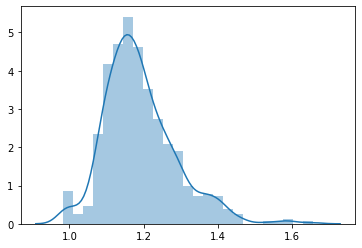

In [24]:
sns.distplot(today_features['predicted_values'].values)

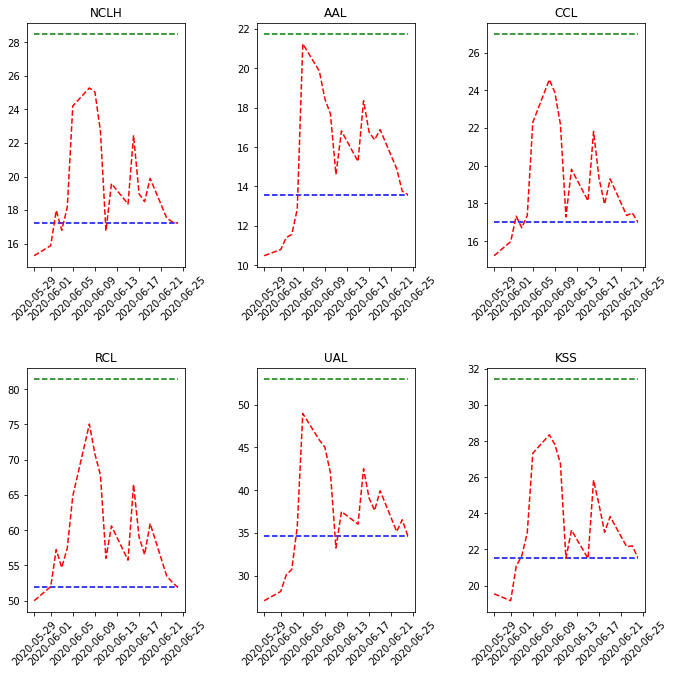

In [25]:
interpret_now(
    test_features=today_features, 
    y_pred=today_y,
    training_start_date=today_pred_start_date,
    training_end_date=today_pred_end_date)

In [98]:
today_features.sort_values(by='predicted_values', ascending=False).head()

,symbol,Open_beta_7,Open_beta_30,Open_beta_30_var,Open_beta_7_var,Open_ma_fac,Open_second_deriv,Open_abcd_pattern,Volume_beta_7,Volume_beta_30,Volume_beta_30_var,Volume_beta_7_var,daily_change_short_mean_val,daily_change_long_mean_val,predicted_values,y_pred
363,OKE,-0.012404,-0.006501,0.029137,0.027642,1.056578,-0.039995,0.000000,-0.002081,-0.162820,0.598565,0.384550,0.060911,0.068357,2.022957,2.022957
462,UAL,-0.026061,-0.005979,0.030830,0.035518,1.043999,-0.038773,0.104424,-0.005062,-0.041039,0.058839,0.207514,0.070316,0.082347,1.896275,1.896275
43,APA,-0.009516,-0.000964,0.027450,0.040188,1.018761,-0.048964,0.000000,-0.024789,-0.034870,0.085082,0.240446,0.067975,0.081866,1.850549,1.850549
394,PVH,-0.018408,-0.016723,0.021541,0.028878,1.054199,-0.025886,0.000000,-0.009546,-0.070149,0.276987,0.266059,0.057401,0.068361,1.848622,1.848622
87,CCL,-0.030460,-0.013882,0.030389,0.042842,1.044381,-0.013739,0.000000,-0.044015,-0.047161,0.039414,0.136561,0.078980,0.089093,1.820795,1.820795


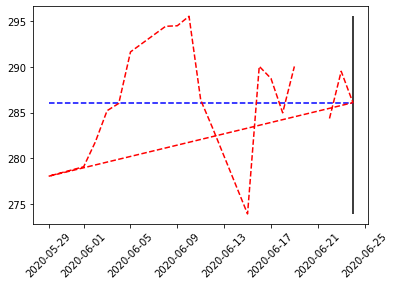

In [99]:
training_start_date = '2020-05-29'
training_end_date = '2020-06-24'
test_end_date = '2020-06-24'

training_start_dt = datetime.strptime(training_start_date, '%Y-%m-%d')
training_end_dt = datetime.strptime(training_end_date, '%Y-%m-%d')
test_end_dt = datetime.strptime(test_end_date, '%Y-%m-%d')
    

df_dates = all_df[
    (all_df['date'] >= training_start_dt) &
    (all_df['date'] <= test_end_dt)
]

df_symbol = df_dates.query("symbol=='VOO'")
current_value = df_symbol.query(f"date=='{training_end_date}'")['Open'].values[0]

df_symbol['date'] = pd.to_datetime(df_symbol['date'])

plt.plot(df_symbol.date, df_symbol.Open, 'r--')
plt.xticks(rotation=45)

plt.vlines(
    x=training_end_dt, 
    ymin=np.min(df_symbol['Open'].values), 
    ymax=np.max(df_symbol['Open'].values)
)

plt.hlines(
    y=current_value,
    xmin=training_start_dt,
    xmax=training_end_dt,
    colors='b',
    linestyles='dashed'
)

In [11]:
training_features.head()

,symbol,Open_beta_7,Open_beta_30,Open_beta_30_var,Open_beta_7_var,Open_ma_fac,Open_second_deriv,Open_abcd_pattern,Volume_beta_7,Volume_beta_30,Volume_beta_30_var,Volume_beta_7_var,daily_change_short_mean_val,daily_change_long_mean_val
0,A,0.003736,0.002268,0.002363,0.011947,1.011168,-0.000222,0.000000,0.331511,0.002370,0.027958,0.547957,0.026940,0.029459
1,AAL,-0.014478,-0.008000,0.007608,0.046384,0.943244,-0.000774,0.000000,-0.012381,-0.013763,0.024119,0.206315,0.065914,0.081994
2,AAP,-0.004770,0.010454,0.005881,0.022852,1.056308,-0.001086,0.059300,0.098124,-0.004148,0.019059,0.108167,0.041074,0.042698
3,AAPL,-0.000803,0.007355,0.002666,0.020706,1.045024,-0.001515,0.000000,0.079924,-0.002989,0.022686,0.168996,0.025769,0.026799
4,ABBV,0.009300,0.005301,0.002153,0.022863,1.031979,-0.001381,0.004504,-0.008644,0.039003,0.040522,0.431406,0.036696,0.032948
